In [300]:
from sympy import symbols, solve, lambdify, sympify, dsolve, Eq, solveset, linear_eq_to_matrix, nonlinsolve, Matrix, diff, sqrt
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import quiver
from scipy import integrate

from ipywidgets import widgets
from IPython.display import clear_output, display

In [106]:
# num_arrows_slider = widgets.IntSlider()
# display(num_arrows_slider)
# num_arrows = num_arrows_slider.value

In [269]:
def rk4( f, x0, t ):
    """Fourth-order Runge-Kutta method to solve x' = f(x,t) with x(t[0]) = x0.

    USAGE:
        x = rk4(f, x0, t)

    INPUT:
        f     - function of x and t equal to dx/dt.  x may be multivalued,
                in which case it should a list or a NumPy array.  In this
                case f must return a NumPy array with the same dimension
                as x.
        x0    - the initial condition(s).  Specifies the value of x when
                t = t[0].  Can be either a scalar or a list or NumPy array
                if a system of equations is being solved.
        t     - list or NumPy array of t values to compute solution at.
                t[0] is the the initial condition point, and the difference
                h=t[i+1]-t[i] determines the step size h.

    OUTPUT:
        x     - NumPy array containing solution values corresponding to each
                entry in t array.  If a system is being solved, x will be
                an array of arrays.
    
    SOURCE: http://www.math-cs.gordon.edu/courses/mat342/python/diffeq.py
    """

    n = len( t )
    x = np.array( [ x0 ] * n, dtype=float )
    for i in range( n - 1 ):
        h = t[i+1] - t[i]
        k1 = h * f( x[i], t[i] )
        k2 = h * f( x[i] + 0.5 * k1, t[i] + 0.5 * h )
        k3 = h * f( x[i] + 0.5 * k2, t[i] + 0.5 * h )
        k4 = h * f( x[i] + k3, t[i+1] )
        x[i+1] = x[i] + ( k1 + 2.0 * ( k2 + k3 ) + k4 ) / 6.0
        print(x[i+1])

    return x


In [210]:
? np.array

In [ ]:
def numericNullCline(f, initial, inputrange):
    for i in inputrange:
        val.append()

In [312]:
def plotEquation (eq, solvar, plotvar, inputrange):
    '''
        Given a sympy equation object `eq`, this function return a series of values,
        in the range of `inputrange` such that the equation is solved for
        `solvar` and the input is for `plotvar`
    '''
    eq = Eq(eq, 0)
    sol = solve(eq, solvar)
    vals = []
    for s in sol:
        f = lambdify((plotvar), sol)
        vals.append([f(i) for i in inputrange])
#         vals.append([f(i)[0] for i in inputrange])
#         vals.append([f(i)[1] for i in inputrange])
#         vals.append( rk4(f, f(inputrange[0])[0], inputrange) )

    return vals

In [283]:
def findFixedPoints(f, g, xrange, yrange):
    return [(x, y) for x in xrange for y in yrange if f(x, y) == 0 and g(x, y) == 0]

In [309]:
def eigenvalues(expr1, expr2):
    a11 = diff(expr1, x)
    a12 = diff(expr1, y)
    
    a21 = diff(expr2, x)
    a22 = diff(expr2, y)
    
    tr = a11 + a22
    det = a11*a22 - a12*a21
    lambda1 = (tr - sqrt(tr**2 - 4*det))/2
    lambda2 = (tr + sqrt(tr**2 - 4*det))/2
    
    print(lambda1)
    print(lambda2)
    
#     print('Check the fixed point  %s, %s' % (x,y))
#     print('The real part of the first eigenvalue is %s' % lambda1.real)
#     print('The real part of the second eigenvalue is %s' % lambda2.real)    
    
#     if (lambda1.real < 0 and lambda2.real < 0):
#         print('The fixed point in %s, %s is a sink. It is stable' % (x,y))
#     if (lambda1.real > 0 and lambda2.real > 0):
#         print('The fixed point in %s, %s is a source. It is unstable' % (x,y))
#     if (lambda1.real > 0 and lambda2.real < 0):
#         print('The fixed point in %s, %s is a saddle. It is unstable' % (x,y))
#     if (lambda1.real < 0 and lambda2.real > 0):
#         print('The fixed point in %s, %s is unstable' % (x,y))
    return lambda1 , lambda2

In [318]:
def on_change():
    clear_output()
    
    yrange = np.linspace(y_range_slider.value[0], y_range_slider.value[1])
    xrange = np.linspace(x_range_slider.value[0], x_range_slider.value[1])
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xlim([min(xrange), max(xrange)])
    ax.set_ylim([min(yrange), max(yrange)])
    
    f1 = lambdify((x, y), expr1)
    f2 = lambdify((x, y), expr2)
    
    f1_val = [[f1(i, j) for i in xrange] for j in yrange];
    f2_val = [[f2(i, j) for i in xrange] for j in yrange];

    q = ax.quiver(xrange, yrange, f1_val, f2_val)
    
#     pp, _ = integrate.odeint(f1, np.array([5, 5]), xrange, full_output=True)
#     ppx, ppy = pp.T
#     fig2, ax2 = plt.subplots(figsize=(10,10))
#     ax2.plot(ppx, ppy)
    
    eigenvalues(expr1, expr2)

    solutions = nonlinsolve([expr1, expr2], x, y)
    
    try:
        [ax.scatter(yrange, nc, c='b', alpha=.4) for nc in plotEquation(expr1, y, x, yrange)]
        [ax.scatter(nc, xrange, c='r', alpha=.4) for nc in plotEquation(expr2, x, y, xrange)]
    except:
        print('Some nullcline values are complex')
    
    try:
        [ax.scatter(i[0], i[1], marker='x', label='Stable Point', s=30) for i in solutions]
    except:
        print('Some roots are complex')

    plt.legend()
    plt.show()


In [313]:
? plt.scatter

In [308]:
x, y = symbols('x y')

# expr1 = 2*x - y + 3*(x**2 - y**2) + 2*x*y
expr1 = 2*x - x**2 - x*y
display(expr1)

# expr2 = x - 3*y - 3*(x**2-y**2) + 3*x*y
expr2 = -y + x*y
display(expr2)

-x**2 - x*y + 2*x

x*y - y

-x/2 - y/2 - sqrt(-4*x*y - 4*(x - 1)*(-2*x - y + 2) + (-x - y + 1)**2)/2 + 1/2
-x/2 - y/2 + sqrt(-4*x*y - 4*(x - 1)*(-2*x - y + 2) + (-x - y + 1)**2)/2 + 1/2


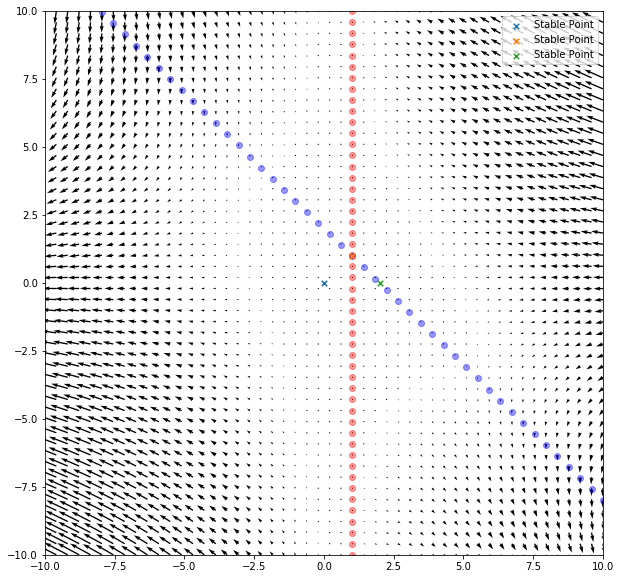

In [306]:
y_range_slider = widgets.IntRangeSlider(min=-10, max=10)
display(y_range_slider)

x_range_slider = widgets.IntRangeSlider(min=-10, max=10)
display(x_range_slider)

# y_range_slider.observe(on_change)
# x_range_slider.observe(on_change)

renderButton = widgets.Button(description='Plot')
display(renderButton)

@renderButton.on_click
def renderButtonOnClick(b):
    on_change()


In [275]:
eqMat = Matrix([ expr1, expr2 ])
Mat = Matrix([ x, y ])
jacMat = eqMat.jacobian(Mat)
print('Jacobian %s' % jacMat)
print('---------------------')

# iterate through list of equilibria
for item in equilibria:
    eqmat = jacMat.subs([ (r, item[0]), (c, item[1]) ])
    print('The eigenvalues for the fixed point (%s, %s) are %s and %s:' 
          %(item[0], item[1], eqmat.eigenvals().keys()[0], eqmat.eigenvals().keys()[1]))

Jacobian Matrix([[6*x + 2*y + 2, 2*x - 6*y - 1], [-6*x + 3*y + 1, 3*x + 6*y - 3]])
---------------------


NameError: name 'equilibria' is not defined